In [1]:
!pip install tensorflow

In [31]:
import os
import zipfile
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.applications import ResNet50, EfficientNetB0, MobileNetV2
from sklearn.metrics import classification_report, confusion_matrix

# LOADING DATASET

In [4]:
zip_path = "Dog_vs_Wolf.zip"
extract_path = "Dog_vs_Wolf"

os.makedirs(extract_path, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [5]:
from pathlib import Path

def is_valid_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except Exception:
        return False

In [6]:
base_folder = "Dog_vs_Wolf/data"
for subfolder in ["dogs", "wolves"]:
    folder_path = os.path.join(base_folder, subfolder)
    for img_file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_file)
        if not is_valid_image(img_path):
            print("Removing corrupted image:", img_path)
            os.remove(img_path)

Showing Training Images

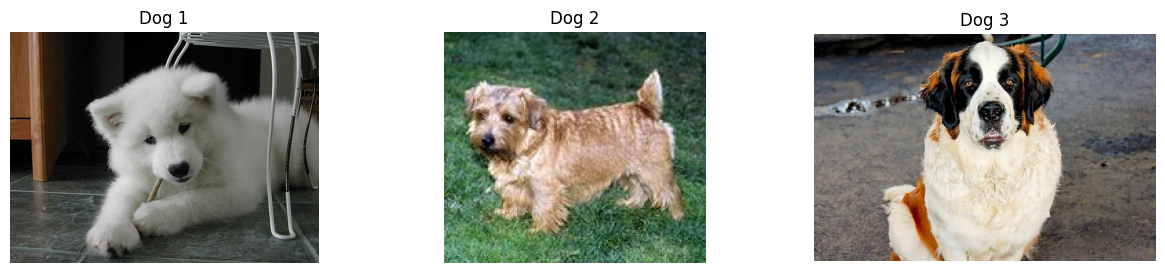

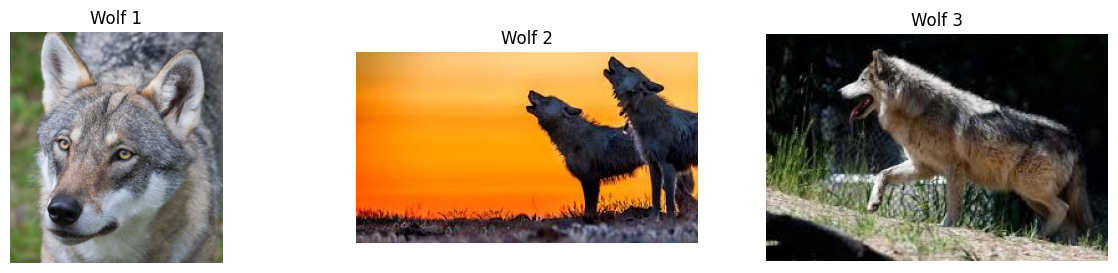

In [10]:
def show_random_images(class_dir, title, n=3):
    images = random.sample(os.listdir(class_dir), n)
    plt.figure(figsize=(15, 3))
    for i, img_file in enumerate(images):
        img_path = os.path.join(class_dir, img_file)
        img = Image.open(img_path)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f"{title} {i+1}")
        plt.axis('off')
    plt.show()

show_random_images("Dog_vs_Wolf/data/dogs", "Dog")
show_random_images("Dog_vs_Wolf/data/wolves", "Wolf")


# Model Training

In [11]:
data_path = "Dog_vs_Wolf/data"
img_size = (150, 150)
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

In [12]:
train_generator = datagen.flow_from_directory(
    data_path, target_size=img_size, batch_size=batch_size,
    class_mode='binary', subset='training', shuffle=True
)


Found 1600 images belonging to 2 classes.


In [13]:
val_generator = datagen.flow_from_directory(
    data_path, target_size=img_size, batch_size=batch_size,
    class_mode='binary', subset='validation', shuffle=False
)

Found 400 images belonging to 2 classes.


In [14]:
base_model = ResNet50(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Resnet

In [15]:
resnet_model = Model(inputs=base_model.input, outputs=x)
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
resnet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,589,761 (89.99 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [16]:
history = resnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 208s 4s/step - accuracy: 0.5081 - loss: 0.7210 - val_accuracy: 0.4650 - val_loss: 0.6944
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.5110 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6940
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 192s 4s/step - accuracy: 0.5081 - loss: 0.7058 - val_accuracy: 0.5000 - val_loss: 0.6952
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.4659 - loss: 0.7130 - val_accuracy: 0.5000 - val_loss: 0.6874
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 201s 4s/step - accuracy: 0.5244 - loss: 0.6962 - val_accuracy: 0.5125 - val_loss: 0.6842
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.5154 - loss: 0.6905 - val_accuracy: 0.6300 - val_loss: 0.6829
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - accuracy: 0.5489 - loss: 0.6838 - val_accuracy: 0.6450 - val_loss: 0.6815
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 185s 4s/step - accuracy: 0.5240 - loss: 0.6857 - val_accuracy: 0.5625 - v

Efficient

In [23]:
base_model_efficient = EfficientNetB0(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model_efficient.trainable = False

x = base_model_efficient.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [24]:
efficient_model = Model(inputs=base_model_efficient.input, outputs=x)
efficient_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
efficient_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [25]:
history_efficient = efficient_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.5049 - loss: 0.6998 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.4911 - loss: 0.7040 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4866 - loss: 0.7014 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.5027 - loss: 0.7004 - val_accuracy: 0.5000 - val_loss: 0.6987
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.4811 - loss: 0.7054 - val_accuracy: 0.5000 - val_loss: 0.6939
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4787 - loss: 0.7043 - val_accuracy: 0.5000 - val_loss: 0.6990
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5054 - loss: 0.7010 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.4651 - loss: 0.7108 - val_accuracy: 0.5000 - val_loss:

Mobilenet

In [26]:
base_model_mobilenet = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model_mobilenet.trainable = False

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(1, activation='sigmoid')(x)

<ipython-input-26-95a5b341479b>:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenet = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [27]:
mobilenet_model = Model(inputs=base_model_mobilenet.input, outputs=x)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 75, 75,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 75, 75,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 75, 75,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 75, 75,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 75, 75,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 75, 75,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 75, 75,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 75, 75,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 77, 77,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 38, 38,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 38, 38,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 38, 38,    │      2,304 │ block_1_depthwis

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
history_mobilenet = mobilenet_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6977 - loss: 0.6329 - val_accuracy: 0.9375 - val_loss: 0.1439
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9064 - loss: 0.2171 - val_accuracy: 0.9550 - val_loss: 0.1121
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9366 - loss: 0.1837 - val_accuracy: 0.9600 - val_loss: 0.1035
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9395 - loss: 0.1460 - val_accuracy: 0.9625 - val_loss: 0.1023
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9338 - loss: 0.1570 - val_accuracy: 0.9650 - val_loss: 0.0871
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9488 - loss: 0.1284 - val_accuracy: 0.9625 - val_loss: 0.0916
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9529 - loss: 0.1233 - val_accuracy: 0.9575 - val_loss: 0.0970
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9326 - loss: 0.1456 - val_accuracy: 0.9750 - val_loss:

SimpleCNN

In [33]:
simplecnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
simplecnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
simplecnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,481 (18.42 MB)

 Trainable params: 4,828,481 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history_simplecnn = simplecnn_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.5600 - loss: 0.7946 - val_accuracy: 0.6525 - val_loss: 0.6522
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 107s 2s/step - accuracy: 0.6464 - loss: 0.6242 - val_accuracy: 0.7175 - val_loss: 0.5771
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7014 - loss: 0.5847 - val_accuracy: 0.7125 - val_loss: 0.5732
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7478 - loss: 0.5386 - val_accuracy: 0.7375 - val_loss: 0.5604
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.7078 - loss: 0.5939 - val_accuracy: 0.7300 - val_loss: 0.5651
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.7707 - loss: 0.5009 - val_accuracy: 0.7175 - val_loss: 0.5644
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.7698 - loss: 0.4966 - val_accuracy: 0.7550 - val_loss: 0.5368
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.7852 - loss: 0.4594 - val_accuracy: 0.7525 - val_lo

# Visualisation

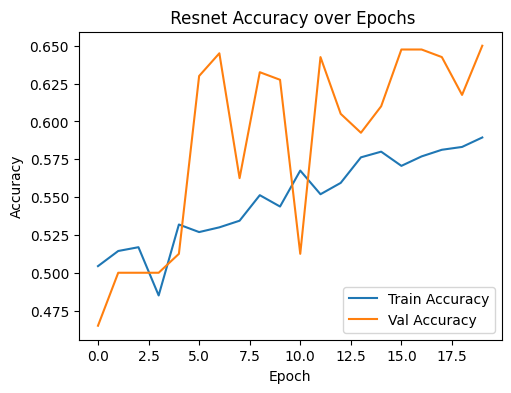

In [53]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title(" Resnet Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

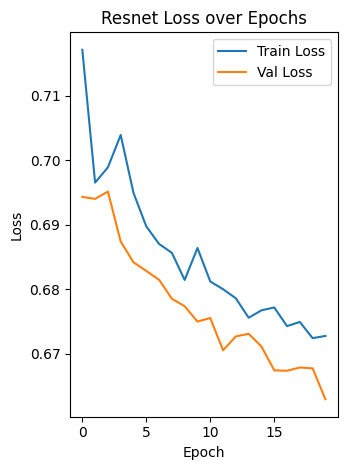

In [54]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Resnet Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

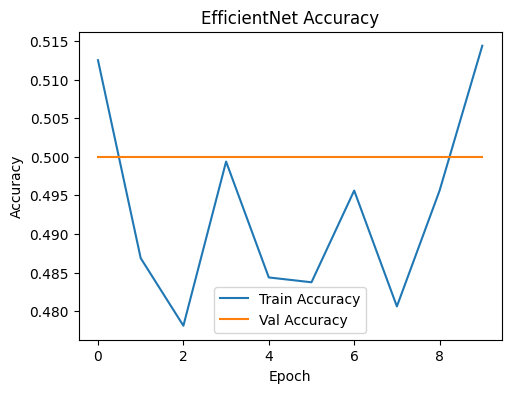

In [38]:
# Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_efficient.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficient.history['val_accuracy'], label='Val Accuracy')
plt.title("EfficientNet Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

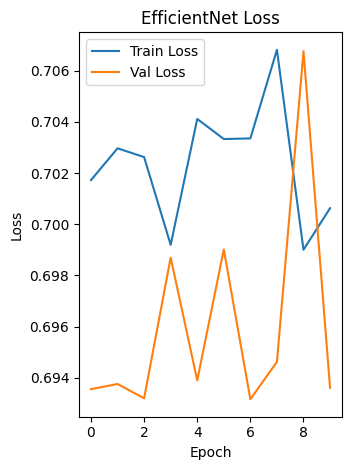

In [39]:
plt.subplot(1, 2, 2)
plt.plot(history_efficient.history['loss'], label='Train Loss')
plt.plot(history_efficient.history['val_loss'], label='Val Loss')
plt.title("EfficientNet Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

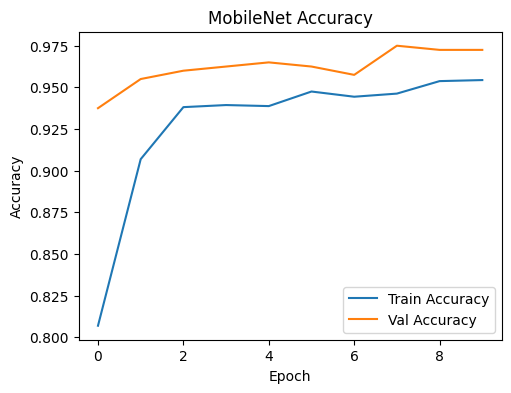

In [40]:
# Accuracy & Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title("MobileNet Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

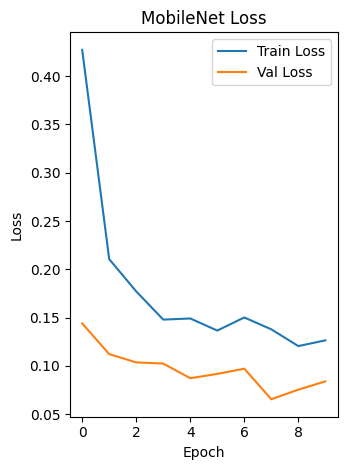

In [41]:
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title("MobileNet Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


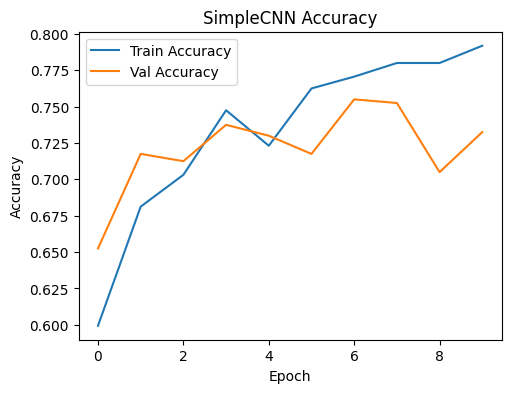

In [42]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_simplecnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_simplecnn.history['val_accuracy'], label='Val Accuracy')
plt.title("SimpleCNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

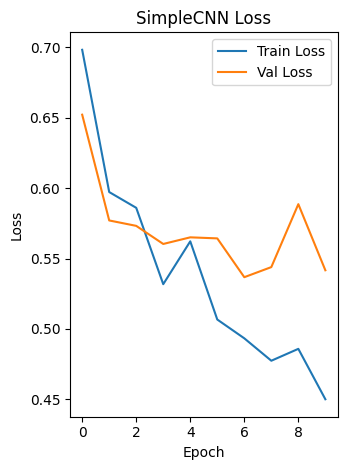

In [43]:
plt.subplot(1, 2, 2)
plt.plot(history_simplecnn.history['loss'], label='Train Loss')
plt.plot(history_simplecnn.history['val_loss'], label='Val Loss')
plt.title("SimpleCNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation Metrics

13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step


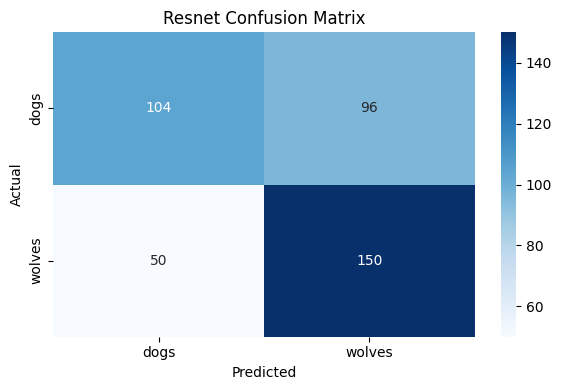

              precision    recall  f1-score   support

        dogs       0.68      0.52      0.59       200
      wolves       0.61      0.75      0.67       200

    accuracy                           0.64       400
   macro avg       0.64      0.64      0.63       400
weighted avg       0.64      0.64      0.63       400



In [55]:
y_pred = resnet_model.predict(val_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Resnet Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=val_generator.class_indices.keys()))


13/13 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step


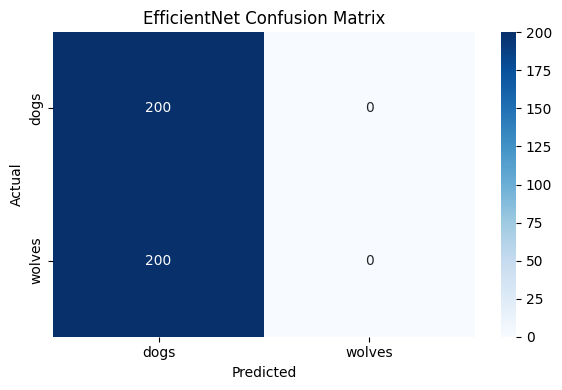

              precision    recall  f1-score   support

        dogs       0.50      1.00      0.67       200
      wolves       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
# Evaluation
y_pred_eff = efficient_model.predict(val_generator)
y_pred_classes_eff = (y_pred_eff > 0.5).astype("int32").flatten()
y_true_eff = val_generator.classes

cm_eff = confusion_matrix(y_true_eff, y_pred_classes_eff)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_eff, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("EfficientNet Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(y_true_eff, y_pred_classes_eff, target_names=val_generator.class_indices.keys()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 987ms/step


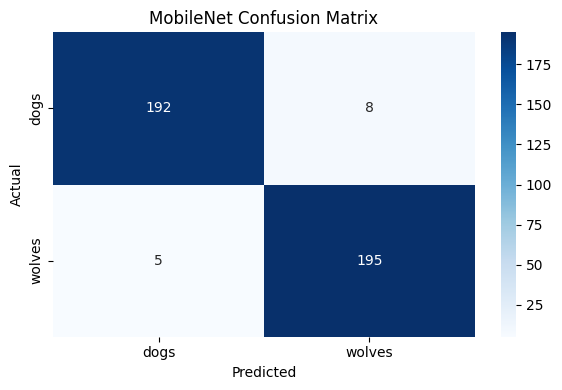

              precision    recall  f1-score   support

        dogs       0.97      0.96      0.97       200
      wolves       0.96      0.97      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



In [46]:
# Evaluation
y_pred_mobile = mobilenet_model.predict(val_generator)
y_pred_classes_mobile = (y_pred_mobile > 0.5).astype("int32").flatten()
y_true_mobile = val_generator.classes

cm_mobile = confusion_matrix(y_true_mobile, y_pred_classes_mobile)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_mobile, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MobileNet Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(y_true_mobile, y_pred_classes_mobile, target_names=val_generator.class_indices.keys()))

13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 920ms/step


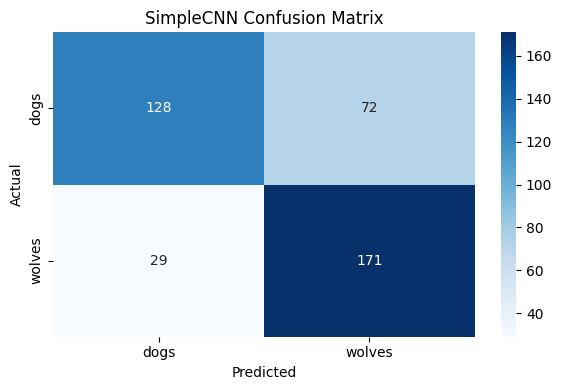

              precision    recall  f1-score   support

        dogs       0.82      0.64      0.72       200
      wolves       0.70      0.85      0.77       200

    accuracy                           0.75       400
   macro avg       0.76      0.75      0.74       400
weighted avg       0.76      0.75      0.74       400



In [47]:
y_pred_simple = simplecnn_model.predict(val_generator)
y_pred_classes_simple = (y_pred_simple > 0.5).astype("int32").flatten()
y_true_simple = val_generator.classes

cm_simple = confusion_matrix(y_true_simple, y_pred_classes_simple)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_simple, annot=True, fmt="d", cmap="Blues",
            xticklabels=val_generator.class_indices.keys(),
            yticklabels=val_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SimpleCNN Confusion Matrix")
plt.tight_layout()
plt.show()

print(classification_report(y_true_simple, y_pred_classes_simple, target_names=val_generator.class_indices.keys()))

# Testing

Resnet

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


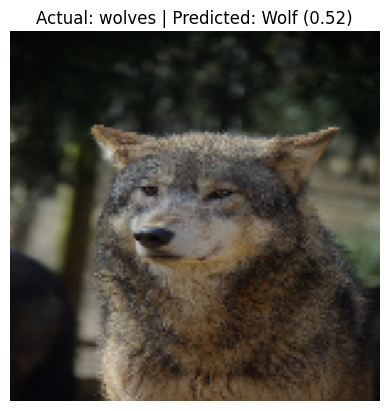

In [50]:
def predict_random_val_image(generator, model):
    idx = random.randint(0, len(generator.filenames) - 1)
    file_path = generator.filepaths[idx]
    true_class = list(generator.class_indices.keys())[generator.classes[idx]]

    img = load_img(file_path, target_size=(150, 150))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)[0][0]
    pred_label = "Wolf" if pred > 0.5 else "Dog"
    confidence = pred if pred_label == "Wolf" else 1 - pred

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Actual: {true_class} | Predicted: {pred_label} ({confidence:.2f})")
    plt.show()

predict_random_val_image(val_generator, resnet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step


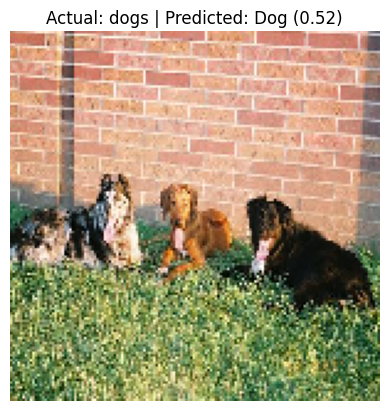

In [51]:
predict_random_val_image(val_generator, resnet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


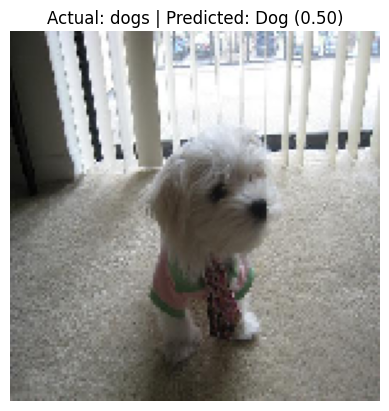

In [52]:
predict_random_val_image(val_generator, resnet_model)

EfficientNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


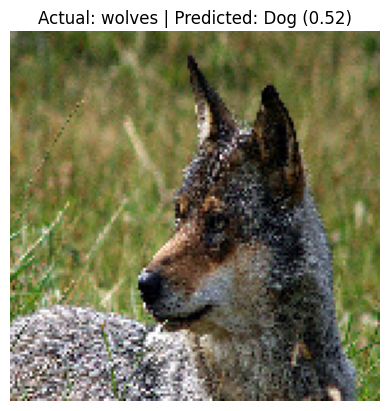

In [56]:
predict_random_val_image(val_generator, efficient_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


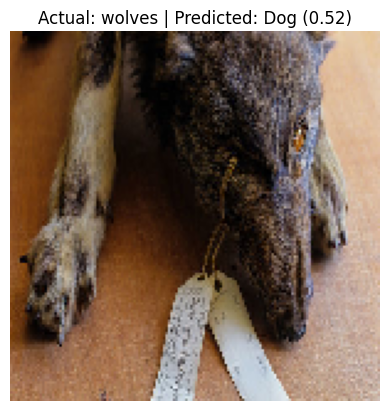

In [57]:
predict_random_val_image(val_generator, efficient_model)

MobileNet

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


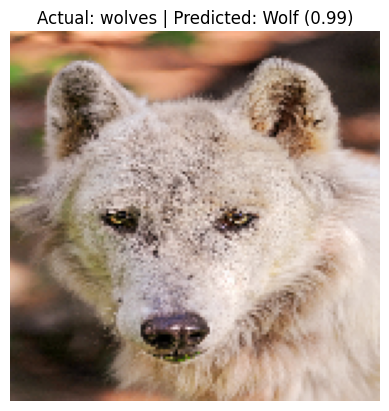

In [58]:
predict_random_val_image(val_generator, mobilenet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


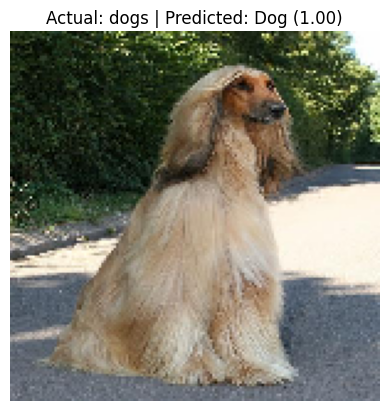

In [59]:
predict_random_val_image(val_generator, mobilenet_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


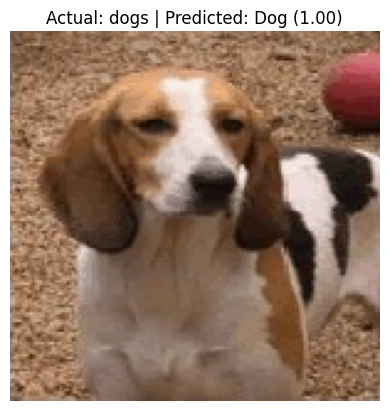

In [60]:
predict_random_val_image(val_generator, mobilenet_model)

SimpleCNN

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


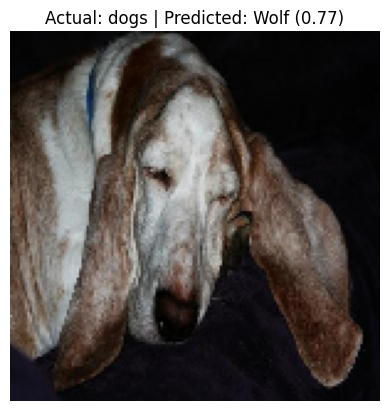

In [61]:
predict_random_val_image(val_generator, simplecnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


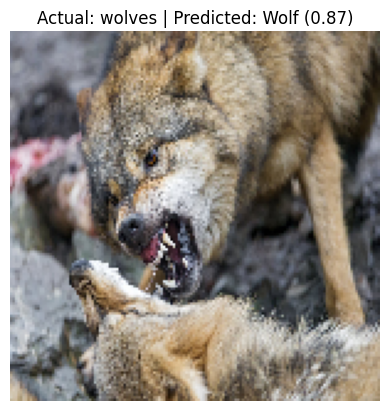

In [62]:
predict_random_val_image(val_generator, simplecnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


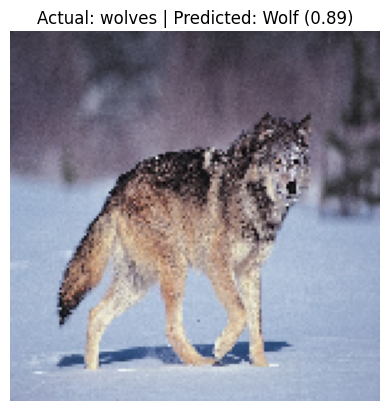

In [65]:
predict_random_val_image(val_generator, simplecnn_model)